# Overview

In this notebook, we demonstrate how we train and test the models in the paper "Developing Generalizable Neural Networks for HRTEM Analysis". To actually run this notebook, you need to have downloaded and/or created the preprocessed datasets (described more in the dataset_creation folder).

As we cover a variety of datasets with various metadata in the paper, for brevity in this notebook, we will outline the training and testing procedure for studying generalizability across nanoparticle size. To test any of the other metadata parameters, one would just need to import another dataset. 

# Import packages

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas import DataFrame
import pandas as pd
from routines import *
from skimage import io, transform
import csv
import copy

# Routines

Below are a number of functions we have written to handle our image dataset, create the network architecture, train the model, and evaluate network performance. 

In [2]:
class TEMImageDataset_Local_PartialRot(Dataset):
  """Creates a Dataset object that takes in numpy arrays of the images and labels, and when querying for an image, augments ~50% of them by random rotation"""

  def __init__(self, image_dataset, labels_dataset, transform_flag = False):
    """ Args:
      image_dataset (array): NxHxW numpy array of the images
      labels_dataset (array): NxHxW numpy array of the labels
      transform (Boolean): whether or not to randomly transform ~half of the dataset
    """
    self.image = image_dataset
    self.labels = labels_dataset
    self.transform_flag = transform_flag
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    
    if self.transform_flag:
        rot_or_not = torch.rand(1).numpy()
        #Rotate ~50% of the images
        if rot_or_not > 0.5:
            #Determine median bkgd value
            bkgd_val = np.median(images[labels==0])
            if np.isnan(bkgd_val):
                bkgd_val = np.median(images)
            #Randomly flip and rotate
            rand_vals = torch.rand(2).numpy()
            if rand_vals[0] < 0.33:
                images[0,:,:] = np.flipud(images[0,:,:])
                labels[0,:,:] = np.flipud(labels[0,:,:])
            elif rand_vals[0] < 0.66:
                images[0,:,:] = np.fliplr(images[0,:,:])
                labels[0,:,:] = np.fliplr(labels[0,:,:])
            
            images[0,:,:] = transform.rotate(images[0,:,:],rand_vals[1]*360,mode='constant',cval=bkgd_val)
            labels[0,:,:] = transform.rotate(labels[0,:,:],rand_vals[1]*360,mode='constant',cval=0)
    sample = {'image': images, 'label': labels}
    
    return sample

#Model classes
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size1, kernel_size2):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size1, padding=(kernel_size1-1)//2)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size2, padding=(kernel_size2-1)//2)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.conv_add = nn.Conv2d(in_channels,out_channels,kernel_size = 1) #Expands/contracts input image in the filter dimension for the ReLU skip connection

    #Copied from torchvision to correctly initialize layers
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    skip = self.conv_add(x)
    out += skip
    out = self.relu2(out)
    return out

class UNet(nn.Module): #Adapted from Erin's code
  def __init__(self, num_blocks,filter_sequence,max_pool_sequence, num_classes = 2):
    #num_blocks: number of residual blocks in network
    #filter_sequence: list of filter sizes
    #kernel_num: the number of kernels that are of size 3
   
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
   
    self.pools = nn.ModuleList()
    self.upsamples = nn.ModuleList()
    

    # creates down and pooling layers
    in_channels = 1
    for i in range(num_blocks):
        self.downs.append(ResidualBlock(in_channels,filter_sequence[i],3,3))
        in_channels = filter_sequence[i]
        self.pools.append(nn.MaxPool2d(kernel_size = max_pool_sequence[i], stride = max_pool_sequence[i]))



    # creates up and upsampling layers
    for i in reversed(range(num_blocks)):
        self.ups.append(ResidualBlock(filter_sequence[i]+filter_sequence[i+1],filter_sequence[i],3,3)) #The 2*filters in the input channels refers to the extra channels from the concat layer
        self.upsamples.append(nn.Upsample(scale_factor=max_pool_sequence[i]))

    # "bottleneck" or middle part at bottom of U
    self.bottleneck = ResidualBlock(filter_sequence[num_blocks-1],filter_sequence[num_blocks],3,3)

    # final convolution with 1x1 kernel
    self.final_conv = nn.Conv2d(filter_sequence[0], num_classes, kernel_size = 1)

    self.num_blocks = num_blocks

  
  def forward(self, x):
  
    skips = [] # empty array to store skip connections

    for i in range(self.num_blocks):
        x = self.downs[i](x)
        skips.append(x)
        x = self.pools[i](x)

    x = self.bottleneck(x)
    skips = skips[::-1] # reverse skips array because we want to work with latest one first

    for idx in range(self.num_blocks):
      x = self.upsamples[idx](x)
      skip = skips[idx]
      concat_skip = torch.cat((skip,x),dim=1)
      x = self.ups[idx](concat_skip)

    out = self.final_conv(x)

    return out

#Training definitions
def train_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.train()
  for batch_i, sample_batch in enumerate(dataloader):
    #Move the images and labels to the GPU
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].type(torch.LongTensor).to(device)

    #Compute the prediction (i.e. forward pass)
    pred = model(images)
    
    #Compute the loss
    loss = loss_fn(pred,labels[:,0,:,:]) #can't have dimensions in the channel index

    #Backpropagation
    #First, reset the gradients of the model parameters
    optimizer.zero_grad()
    #Back prop the prediction loss
    loss.backward()
    #Adjust the parameters using the gradients collected
    optimizer.step()

    #Log the loss and dice score
    avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
    dice_score += compute_dice(pred, labels, device).item()
    hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size

def test_loop(dataloader, model, loss_fn, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  num_oversegment = 0
  num_undersegment = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, sample_batch in enumerate(dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred = model(images)
      #Compute the loss
      loss = loss_fn(pred,labels[:,0,:,:]) 
      #Log the loss and dice score
      avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
      dice_score += compute_dice(pred, labels, device).item()
      hard_dice += compute_dice_hard(pred, labels, device).item()
      #Analyze under/oversegmentation
      fneg, fpos = false_negpos(pred, labels, device)
      num_oversegment += fpos.item()
      num_undersegment += fneg.item()
  
  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size, num_oversegment/(num_oversegment+num_undersegment)


def compute_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = sm_layer(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def compute_dice_hard(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = torch.round(sm_layer(y_pred)) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

# Function to test a trained model on a specific dataset
def test_model(model, test_imgs, test_lbls, device, b_size, loss_fn):
    test_dataset = TEMImageDataset_Local_PartialRot(test_imgs,test_lbls, transform_flag = False)
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=2)
    #Run through model
    test_loss, test_dice, test_hard_dice = test_loop(test_dataloader, model, loss_fn, device)
    return test_loss, test_dice, test_hard_dice

# Function to shuffle, augment (via rotations and flips), and convert a dataset into PyTorch format
def shuffle_Aug_PyTorch(imgs, lbls, seed):
    #Expand dimensions
    img_dataset = np.expand_dims(imgs, axis=3)
    lbl_dataset = np.expand_dims(lbls, axis=3)
    
    #Augment, shuffle, and convert to PyTorch format
    img_dataset, lbl_dataset = dihedral_augmentation(img_dataset,lbl_dataset)
    img_dataset, lbl_dataset = shuffle_dataset(img_dataset, lbl_dataset, seed)
    img_dataset = pyTorch_format(img_dataset)
    lbl_dataset = pyTorch_format(lbl_dataset)
    
    return img_dataset, lbl_dataset

# Train Models

We're going to first train a set of models on the 2.2nm Au nanoparticle dataset. As described in the paper, we implement a 5-fold cross validation training protocol, in which we train 5 models that use different samplings of the entire dataset as their training and test sets. 

First, we will load the images and corresponding labels:

In [6]:
img_filepath = 'Datasets/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Labels.h5'
img_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

Next, we split up the entire dataset into 5 folds:

In [7]:
k_folds = 5

#Split the dataset and labels into k sub-arrays

imgs_folds = np.array_split(img_dataset, k_folds)
lbls_folds = np.array_split(label_dataset, k_folds)

The dataset is then split such that fold i is held out as the test set, and the rest of the dataset is used for training the model. For the data that is not part of the test set, 1/8th is used as a validation set, and the rest is designated as the training set, such that there is a total 70-10-20% training-validation-test set split. The validation set is used to determine which model is saved as the "best-performing" model within the 250 epochs. 

Each fold also uses different initial conditions (set by the random seed). 

In [57]:
random_seeds = [962, 1662, 621, 72115, 45521]
fold_size = img_dataset.shape[0]//k_folds

for i in range(k_folds):
    print ('\n Fold #: ', str(i))
    # Create training, validation, and test set for the ith fold
    # Validation set is only used to verify that the model has converged
    copy_imgs_list = imgs_folds.copy()
    copy_lbls_list = lbls_folds.copy()
    test_dataset = copy_imgs_list.pop(i)
    test_lbls = copy_lbls_list.pop(i)
    train_dataset = np.concatenate(copy_imgs_list)
    train_lbls = np.concatenate(copy_lbls_list)
    valid_set_size = int(12.5*train_dataset.shape[0]//100)
    if i != (k_folds-1):
        valid_dataset = train_dataset[i*fold_size:(i*fold_size+valid_set_size),:,:]
        valid_lbls = train_lbls[i*fold_size:(i*fold_size+valid_set_size),:,:]
        train_dataset = np.concatenate((train_dataset[:i*fold_size,:,:],train_dataset[(i*fold_size+valid_set_size):,:,:]))
        train_lbls = np.concatenate((train_lbls[:i*fold_size,:,:],train_lbls[(i*fold_size+valid_set_size):,:,:]))
    else: #if i==k_folds-1
        valid_dataset = train_dataset[(i*fold_size-valid_set_size):,:,:]
        valid_lbls = train_lbls[(i*fold_size-valid_set_size):,:,:]
        train_dataset = train_dataset[:(i*fold_size-valid_set_size),:,:]
        train_lbls = train_lbls[:(i*fold_size-valid_set_size),:,:]
    
    # Augment and shuffle
    train_dataset, train_lbls = shuffle_Aug_PyTorch(train_dataset, train_lbls,9201)
    valid_dataset, valid_lbls = shuffle_Aug_PyTorch(valid_dataset, valid_lbls,6274)
    
    # Setup dataset
    training_dataset = TEMImageDataset_Local_PartialRot(train_dataset,train_lbls, transform_flag = True)
    validation_dataset = TEMImageDataset_Local_PartialRot(valid_dataset,valid_lbls, transform_flag = False)
    
    #Setup the data loader
    train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(validation_dataset, batch_size=b_size, shuffle=True, num_workers=4)
    
    # Setup training parameters
    learning_rate = 1e-4
    b_size = 32
    epochs = 250

    seed_num = random_seeds[i]
    torch.manual_seed(seed_num)
    
    #Specify model parameters
    num_blocks = 4
    filter_sequence = [4,8,16,32,64,128,256,512]
    pool_sequence = [2,2,2,2]
    model = UNet(num_blocks,filter_sequence,pool_sequence)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    #Setup GPU and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #Set the logging variables
    history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'recorded_epoch': [], 'time': []}
    
    #Run the training
    best_loss = 1000
    for t in range(epochs):
        start_time=time.time()
        avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
        history['loss'].append(avg_loss)
        history['dice_coef'].append(avg_dice)
        history['hard_dice_coef'].append(avg_hard_dice)
        val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, device)
        history['val_loss'].append(val_loss)
        history['val_dice_coef'].append(val_dice)
        history['val_hard_dice_coef'].append(val_hard_dice)  
        end_time = time.time()
        history['time'].append(end_time-start_time)
        # Record weights if this is the best model so far
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict()) #Needs to be a copy, otherwise it's just a pointer
            recorded_epoch = t
        history['recorded_epoch'].append(recorded_epoch)
        print('Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Recorded Epoch: '+str(recorded_epoch)+ ' Time: '+str(end_time-start_time), end='\r')
    
    
    #Save model and history file
    model.load_state_dict(best_model_state)
    torch.save(model, 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'+str(i)+'_seed'+str(seed_num)+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'+str(i)+'_seed'+str(seed_num)+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
      history_dataframe.to_csv(f)


 Fold #:  0
Epoch: 249 Val Dice: 0.7391742025102888 Recorded Epoch: 153 Time: 12.466512441635132
 Fold #:  1
Epoch: 249 Val Dice: 0.7131635529654367 Recorded Epoch: 138 Time: 12.483428478240967
 Fold #:  2
Epoch: 249 Val Dice: 0.78779296875 Recorded Epoch: 209 Time: 12.40460038185119674146
 Fold #:  3
Epoch: 249 Val Dice: 0.7879145349775042 Recorded Epoch: 185 Time: 12.467186450958252
 Fold #:  4


This procedure can then be repeated for any other dataset.

# Testing models

When testing our models' performance, we have two scenarios:
1. We are testing on a test set drawn from the same dataset, in which case the test set needs to correspond with the correct fold number
2. We are testing on a new dataset, which has no overlap with the training data. 

We've written two functions, test_sim and test_diff, which cover the above two scenarios. Each function takes the entire dataset and the model filename, and then selects the correct test dataset for each model. It then tests all five models, saves the performance of each one, and prints the average performance. 

In [8]:
def test_sim(model_filepath_start, dataset, labels, save_fpath):
    # model_filepath_start is a string of the model filepath before the random seed and fold info
    # dataset is a numpy array of the dataset of images you wish to test on (not just test set)
    # labels is a numpy array of the labels of the dataset you wish to test on
    # save_fpath is a string of the filepath where you want to save the testing results
    
    # Split up into k=5 folds
    k_fold_results = {'fold': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
    k_folds = 5
    random_seeds = [962, 1662, 621, 72115, 45521]
    imgs_folds = np.array_split(dataset, k_folds)
    lbls_folds = np.array_split(labels, k_folds)
    
    num_blocks = 4
    filter_sequence = [4,8,16,32,64,128,256,512]
    pool_sequence = [2,2,2,2]
    model = UNet(num_blocks,filter_sequence,pool_sequence)
    
    for i in range(k_folds): # For every k-fold model
        # Grab correct test set
        test_dataset = imgs_folds[i]
        test_lbls = lbls_folds[i]
        test_dataset, test_lbls = shuffle_Aug_PyTorch(test_dataset, test_lbls,7427)
        
        # Load model
        seed_num = random_seeds[i]
        model_filepath = model_filepath_start+str(i)+'_seed'+str(seed_num)+'_model.h5'
        model_details = torch.load(model_filepath)
        model.load_state_dict(nn.Module.state_dict(model_details))
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        b_size = 32
        loss_fn = nn.CrossEntropyLoss()
        
        # Run test set through model
        test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn)
        
        # Record values
        k_fold_results['fold'].append(i)
        k_fold_results['test_loss'].append(test_loss)
        k_fold_results['test_dice'].append(test_dice)
        k_fold_results['test_hard_dice'].append(test_hard_dice)
    
    # Save csv
    results_dataframe = DataFrame(k_fold_results)
    with open(save_fpath, mode='w') as f:
        results_dataframe.to_csv(f)
    
    avg_loss = np.mean(k_fold_results['test_loss'])
    std_loss = np.std(k_fold_results['test_loss'])
    avg_hd = np.mean(k_fold_results['test_hard_dice'])
    std_hd = np.std(k_fold_results['test_hard_dice'])
    
    return avg_loss, std_loss, avg_hd, std_hd

In [9]:
def test_diff(model_filepath_start, dataset, labels, save_fpath):
    # model_filepath_start is a string of the model filepath before the random seed and fold info
    # dataset is a numpy array of the dataset of images you wish to test on
    # labels is a numpy array of the labels of the dataset you wish to test on
    # save_fpath is a string of the filepath where you want to save the testing results
    
    k_folds = 5
    k_fold_results = {'fold': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
    random_seeds = [962, 1662, 621, 72115, 45521]
    
    num_blocks = 4
    filter_sequence = [4,8,16,32,64,128,256,512]
    pool_sequence = [2,2,2,2]
    model = UNet(num_blocks,filter_sequence,pool_sequence)
    
    # Same dataset for every k-fold model
    test_dataset, test_lbls = shuffle_Aug_PyTorch(dataset, labels, 7427)
    
    for i in range(k_folds): # For every k-fold model
        # Load model
        seed_num = random_seeds[i]
        model_filepath = model_filepath_start+str(i)+'_seed'+str(seed_num)+'_model.h5'
        model_details = torch.load(model_filepath)
        model.load_state_dict(nn.Module.state_dict(model_details))
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        b_size = 32
        loss_fn = nn.CrossEntropyLoss()
        
        # Run test set through model
        test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn)
        
        # Record values
        k_fold_results['fold'].append(i)
        k_fold_results['test_loss'].append(test_loss)
        k_fold_results['test_dice'].append(test_dice)
        k_fold_results['test_hard_dice'].append(test_hard_dice)
   
    # Save csv
    results_dataframe = DataFrame(k_fold_results)
    with open(save_fpath, mode='w') as f:
        results_dataframe.to_csv(f)
    
    avg_loss = np.mean(k_fold_results['test_loss'])
    std_loss = np.std(k_fold_results['test_loss'])
    avg_hd = np.mean(k_fold_results['test_hard_dice'])
    std_hd = np.std(k_fold_results['test_hard_dice'])
    
    return avg_loss, std_loss, avg_hd, std_hd

With these functions, we can then test our models' performance on various test sets. As an example, we will test the models trained on the 2.2nm dataset on images of various nanoparticle diameters (the first row of Figure 4b). 

In [11]:
# Load the datasets
img_filepath = 'Datasets/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Labels.h5'
img_2p2nm_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_2p2nm_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

img_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Images.h5'
label_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Labels.h5'
img_5nm_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_5nm_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

img_filepath = 'Datasets/Au_10nm_330kx_425e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Au_10nm_330kx_425e_Std_UTC_FFCorr_Team05_Labels.h5'
img_10nm_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_10nm_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

In [12]:
# 2.2nm models tested on 2.2nm images
model_filepath_start = 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'
save_fpath = 'model_testing_results/Model2p2nm_Test2p2nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_sim(model_filepath_start, img_2p2nm_dataset, label_2p2nm_dataset, save_fpath)
print('2.2nm Model Tested on 2.2nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 2.2nm Images
Loss:  0.13804369014753423  +/-  0.02361141512324734
Hard Dice:  0.8114719222968733  +/-  0.02720168994224298


In [15]:
# 2.2nm models tested on 5nm images
model_filepath_start = 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'
save_fpath = 'model_testing_results/Model2p2nm_Test5nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_5nm_dataset, label_5nm_dataset, save_fpath)
print('2.2nm Model Tested on 5nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 5nm Images
Loss:  0.08321955988969283  +/-  0.004529977679256041
Hard Dice:  0.8926733016967774  +/-  0.005130460674910355


In [16]:
# 2.2nm models tested on 10nm images
model_filepath_start = 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'
save_fpath = 'model_testing_results/Model2p2nm_Test10nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_10nm_dataset, label_10nm_dataset, save_fpath)
print('2.2nm Model Tested on 10nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 10nm Images
Loss:  0.04560710093937814  +/-  0.0031617042625610692
Hard Dice:  0.901141170039773  +/-  0.005456785793881382


We can also visualize the performance by looking at some random examples. Again, as an example, we will look at how a model trained on 2.2nm nanoparticle images performs on images of various nanoparticle sizes.

In [15]:
# Choose a model fold #
fold_num = 3

# Setup model
num_blocks = 4
filter_sequence = [4,8,16,32,64,128,256,512]
pool_sequence = [2,2,2,2]
model = UNet(num_blocks,filter_sequence,pool_sequence)

random_seeds = [962, 1662, 621, 72115, 45521]
model_filepath_start = 'trained_models/UNet_2p2nmAu330kX423eUTC_fold'
seed_num = random_seeds[fold_num]
model_filepath = model_filepath_start+str(fold_num)+'_seed'+str(seed_num)+'_model.h5'
model_details = torch.load(model_filepath)
model.load_state_dict(nn.Module.state_dict(model_details))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Grab the correct test set (for the 2.2nm dataset)
k_folds = 5
imgs_folds = np.array_split(img_2p2nm_dataset, k_folds)
lbls_folds = np.array_split(label_2p2nm_dataset, k_folds)
test_2p2nm_imgs = imgs_folds.pop(fold_num)
test_2p2nm_lbls = lbls_folds.pop(fold_num)

# Augment, shuffle, and convert test datasets into PyTorch format, and then create dataloaders
# Note that we set the DataLoader's shuffle to False in order to correlate predictions with the images/labels. 
# We could shuffle in the Dataloader if we kept track of the imgs/labels being drawn per batch
# Therefore, if you want to shuffle the order of the dataset, you can modify the random seed in shuffle_Aug_PyTorch (3rd argument)
# If we wanted to test on the unique test set images (i.e. no rotation/flipping augmentations), then we would only need to shuffle and convert to PyTorch format

b_size = 32
test_2p2nm_imgs, test_2p2nm_lbls = shuffle_Aug_PyTorch(test_2p2nm_imgs, test_2p2nm_lbls,7427)
test_2p2nm_dataset = TEMImageDataset_Local_PartialRot(test_2p2nm_imgs,test_2p2nm_lbls, transform_flag = False)
test_2p2nm_dataloader = DataLoader(test_2p2nm_dataset, batch_size=b_size, shuffle=False, num_workers=2)

test_5nm_imgs, test_5nm_lbls = shuffle_Aug_PyTorch(img_5nm_dataset, label_5nm_dataset,7427)
test_5nm_dataset = TEMImageDataset_Local_PartialRot(test_5nm_imgs,test_5nm_lbls, transform_flag = False)
test_5nm_dataloader = DataLoader(test_5nm_dataset, batch_size=b_size, shuffle=False, num_workers=2)

test_10nm_imgs, test_10nm_lbls = shuffle_Aug_PyTorch(img_10nm_dataset, label_10nm_dataset,7427)
test_10nm_dataset = TEMImageDataset_Local_PartialRot(test_10nm_imgs,test_10nm_lbls, transform_flag = False)
test_10nm_dataloader = DataLoader(test_10nm_dataset, batch_size=b_size, shuffle=False, num_workers=2)

In [16]:
def output_predictions(test_dataloader, model, device):
    # model is already assumed to be on GPU
    # Set model to eval mode (important for BatchNorm layers)
    model.eval()
    with torch.no_grad():
        for batch_i, sample_batch in enumerate(test_dataloader):
            # Run images through network
            images = sample_batch['image'].to(device)
            pred = model(images)
            sm_layer = nn.Softmax2d()
            pred = sm_layer(pred)
            # Add predictions to total list
            if batch_i==0:
                pred_total = pred
            else:
                pred_total = torch.cat((pred_total,pred),dim=0)
    # Return the predictions as numpy array on cpu
    return pred_total.detach().cpu().numpy()

def compute_dice_hard_list(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  y_pred = torch.round(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth)

In [19]:
pred_2p2nm = output_predictions(test_2p2nm_dataloader, model, device)
pred_5nm = output_predictions(test_5nm_dataloader, model, device)
pred_10nm = output_predictions(test_10nm_dataloader, model, device)

Finally, we want to be able to both visualize N random examples, and know the corresponding hard dice scores for each prediction. 

In [32]:
def plot_examples(imgs,lbls,pred,device,num_examples=4):
    sample_num = np.random.choice(imgs.shape[0],num_examples,replace=False)
    plt.figure(figsize=(6,num_examples*2))
    for i in range(num_examples):
        plt.subplot(num_examples,3,3*i+1)
        plt.imshow(imgs[sample_num[i],0,:,:], cmap='gray',vmin=-4,vmax=4)
        plt.axis('off')
        if i==0:
            plt.title('Image')
        plt.subplot(num_examples,3,3*i+2)
        plt.imshow(imgs[sample_num[i],0,:,:], cmap='gray',vmin=-4,vmax=4)
        plt.imshow(lbls[sample_num[i],0,:,:],alpha=0.6)
        plt.axis('off')
        if i==0:
            plt.title('Label')
        plt.subplot(num_examples,3,3*i+3)
        plt.imshow(imgs[sample_num[i],0,:,:], cmap='gray',vmin=-4,vmax=4)
        plt.imshow(pred[sample_num[i],1,:,:]>0.5,alpha=0.6)
        plt.axis('off')
        if i==0:
            plt.title('Prediction')
    plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99,wspace=0.1,hspace=0.05)
    
    # Compute hard dice scores:
    hd_scores = compute_dice_hard_list(torch.tensor(pred[sample_num,:,:,:]).to(device), torch.tensor(lbls[sample_num,:,:,:]).type(torch.LongTensor).to(device), device, smooth=1).cpu().numpy()
    return sample_num, hd_scores

Now we can run the following cells to see the predictions - every time we rerun them, they will output 4 random examples.

Sample numbers shown:  [278 129 403 141]
Corresponding Hard Dice Scores:  [0.84903896 0.00204499 0.86922836 0.81907165]


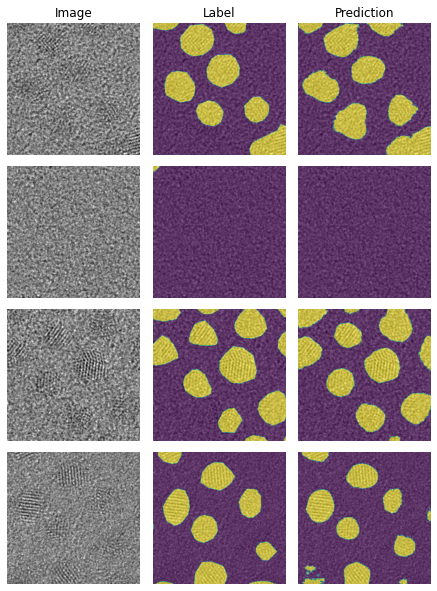

In [40]:
# 2.2nm dataset
samples_plted, hd_scores = plot_examples(test_2p2nm_imgs, test_2p2nm_lbls,pred_2p2nm,device,num_examples=4)
print('Sample numbers shown: ', samples_plted)
print('Corresponding Hard Dice Scores: ', hd_scores)

Sample numbers shown:  [1556 1348   20  242]
Corresponding Hard Dice Scores:  [0.8072318  0.91691303 0.8916157  0.9530134 ]


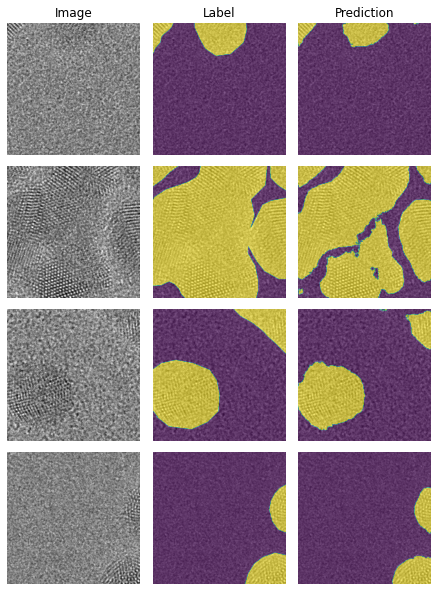

In [56]:
# 5nm dataset
samples_plted, hd_scores = plot_examples(test_5nm_imgs, test_5nm_lbls,pred_5nm,device,num_examples=4)
print('Sample numbers shown: ', samples_plted)
print('Corresponding Hard Dice Scores: ', hd_scores)

Sample numbers shown:  [1002   42  895  106]
Corresponding Hard Dice Scores:  [0.9626316  0.97740114 0.00107411 0.98193437]


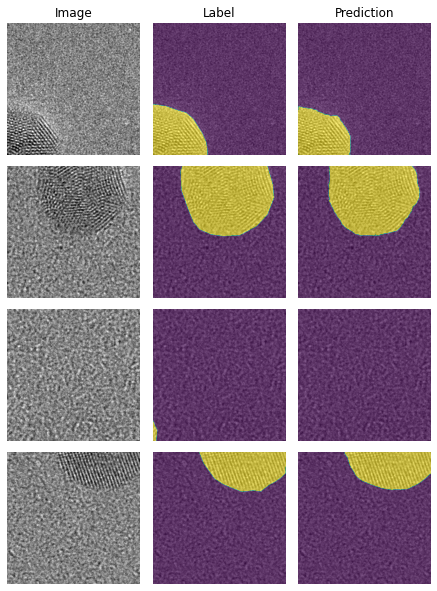

In [65]:
# 10nm dataset
samples_plted, hd_scores = plot_examples(test_10nm_imgs, test_10nm_lbls,pred_10nm,device,num_examples=4)
print('Sample numbers shown: ', samples_plted)
print('Corresponding Hard Dice Scores: ', hd_scores)

For an interactive widget form of the above testing, please see our Google CoLab notebook here (LINK TO BE ADDED)